# Anthropogenic heat from buildings

This notebook is used to process building energy use, analyze data, and ultimately produce the anthropogenic heat flux (AHF) from buildings for the Greater Los Angeles (LA) region.

In [40]:
# load packages 
%matplotlib inline
import os
from pathlib import Path
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
#import requests
import geopandas as gpd
import pyproj
import shapely.geometry
import contextily as ctx
from matplotlib.ticker import FormatStrFormatter
import geofeather

## Import data from data repositories

Download Energy Atlas data from Kaggle repo (if not already in local directory)

In [47]:
energy_atlas_data_path = Path('data/energy_atlas')
if not os.path.isdir(energy_atlas_data_path): # if data directory does not exist (i.e., data not downloaded yet)
    # initialize kaggle API
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    api.authenticate()

    # download from my Kaggle dataset page
    dataset = 'josephko/la-energy-atlas-2016'
    download_path = Path('data/energy_atlas')
    api.dataset_download_files(dataset, download_path) # downloads all data in zip file
    
    # unzip and remove zip file
    zip_file = download_path / 'la-energy-atlas-2016.zip'
    with zipfile.ZipFile(zip_file) as file:
        file.extractall(download_path)
    os.remove(zip_file)


Import Energy Atlas data into dataframes

In [48]:
usage_file = energy_atlas_data_path / 'usage_bld_btu.csv'
usage_bld_btu = pd.read_csv(usage_file, na_values = ['masked'])
#usage_bld_btu = usage_bld_btu.loc[usage_bld_btu['usage'] != 'masked'].copy()

# # TESTING 
# cols = usage_bld_btu.columns.drop(['geo_id', 'usetype', 'name'])
# usage_bld_btu.loc[:,cols] = usage_bld_btu.loc[:, cols].apply(pd.to_numeric, errors = 'coerce')

usage_bld_btu

geo_id       sqft         usage     usage_med  usage_med_sqft  \
0             cities_1     1253.0           NaN           NaN             NaN   
1             cities_1  4820002.0  3.079439e+11  5.522517e+08      46351.2600   
2             cities_1  8916603.0  3.715327e+11  7.530818e+07      34141.0256   
3             cities_1   735816.0           NaN           NaN             NaN   
4             cities_1   100192.0           NaN           NaN             NaN   
...                ...        ...           ...           ...             ...   
5767  neighborhoods_99    30060.0           NaN           NaN             NaN   
5768  neighborhoods_99        0.0           NaN           NaN             NaN   
5769  neighborhoods_99  3452091.0  1.350114e+11  9.211511e+07      35663.1742   
5770  neighborhoods_99  1525718.0  6.178565e+10  7.913064e+07      37415.2632   
5771  neighborhoods_99        NaN           NaN           NaN             NaN   

                usetype  year  pct_elec    pct_ng          name     pop  \
0           agriculture  2016       NaN       NaN  agoura hills     NaN   
1            commercial  2016  0.729374  0.270626  agoura hills     NaN   
2                 condo  2016  0.401412  0.598588  agoura hills     NaN   
3            industrial  2016       NaN       NaN  agoura hills     NaN   
4         institutional  2016       NaN       NaN  agoura hills     NaN   
...                 ...   ...       ...       ...           ...     ...   
5767  residential_other  2016       NaN       NaN       carthay     NaN   
5768  residential_uncat  2016       NaN       NaN       carthay     NaN   
5769          res_total  2016  0.325581  0.674419       carthay  5201.0   
5770      single_family  2016  0.352719  0.647281       carthay     NaN   
5771              uncat  2016       NaN       NaN       carthay     NaN   

      usage_percap  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
5767           NaN  
5768           NaN  
5769  2.595873e+07  
5770           NaN  
5771           NaN  

[5772 rows x 12 columns]

In [49]:
usage_bld_btu.dtypes

geo_id             object
sqft              float64
usage             float64
usage_med         float64
usage_med_sqft    float64
usetype            object
year                int64
pct_elec          float64
pct_ng            float64
name               object
pop               float64
usage_percap      float64
dtype: object

Import geos.csv which has auxiliary information e.g., city names

In [50]:
geos_file = energy_atlas_data_path / 'geos.csv'
geos = pd.read_csv(geos_file, na_values = ['NaN'])
geos

geo_id                 name     pop      pop_sqmi  med_income  \
0        cogs_5  Westside Cities COG  785154   3929.845670    78816.75   
1     cities_39     la habra heights    6310    702.993351   111373.50   
2     cities_40     hawaiian gardens   14076  10142.296070    67831.00   
3     cities_41            hawthorne   86783   9801.098133    48678.25   
4     cities_42             palmdale  148945    947.283953    59654.75   
..          ...                  ...     ...           ...         ...   
957    cities_4                azusa   45301   3204.573593    59007.00   
958  cities_173               irvine   -7777  -7777.000000    -7777.00   
959  cities_182        newport beach   -7777  -7777.000000    -7777.00   
960  cities_183               orange   -7777  -7777.000000    -7777.00   
961  cities_178         laguna woods   -7777  -7777.000000    -7777.00   

         pct_own     pct_rent  year  enviroscreen_tracts        sqmi  \
0       0.051352     0.622423  2010                 16.0  199.792579   
1       0.934310     0.065690  2010                  0.0    8.975903   
2       0.450913     0.549087  2010                  1.0    1.387851   
3       0.272886     0.727080  2010                 15.0    8.854416   
4       0.675369     0.324607  2010                  0.0  157.233741   
..           ...          ...   ...                  ...         ...   
957     0.567021     0.432654  2010                  4.0   14.136358   
958 -7777.000000 -7777.000000  2010                  0.0   95.894530   
959 -7777.000000 -7777.000000  2010                  0.0   37.307898   
960 -7777.000000 -7777.000000  2010                  1.0   36.512519   
961 -7777.000000 -7777.000000  2010                  0.0    4.775987   

        solar_pot  net_solar_pot     count  
0    2.993137e+09          -8888  218333.0  
1    2.343956e+07          -8888    2247.0  
2    4.271364e+07          -8888    2569.0  
3    3.889526e+08          -8888   12879.0  
4    1.077350e+09          -8888   48080.0  
..            ...            ...       ...  
957  2.555376e+08          -8888   -9999.0  
958           NaN          -8888   -7777.0  
959           NaN          -8888   -7777.0  
960           NaN          -8888   -7777.0  
961           NaN          -8888   -7777.0  

[962 rows x 13 columns]

Merge consumption data with geos information, and also add additional useful columns

In [51]:
usage_bld = pd.merge(usage_bld_btu, geos, how='left', on = 'geo_id')
usage_bld.columns

Index(['geo_id', 'sqft', 'usage', 'usage_med', 'usage_med_sqft', 'usetype',
       'year_x', 'pct_elec', 'pct_ng', 'name_x', 'pop_x', 'usage_percap',
       'name_y', 'pop_y', 'pop_sqmi', 'med_income', 'pct_own', 'pct_rent',
       'year_y', 'enviroscreen_tracts', 'sqmi', 'solar_pot', 'net_solar_pot',
       'count'],
      dtype='object')

## Import building footpring (LARIAC) and parcels data

IMPORTANT NOTE:<br>
LARIAC height and area (i.e., building footprint) area in units of FEET not meters

Loading the whole LARIAC and parcels datasets takes a lot of memory. 
For now, load sample LARIAC and parcels for the University Park (USC) subset. 

In [734]:
"""
Note: the shape_area and shape_length attributes are INCORRECT when downloaded from https://geohub.lacity.org/datasets/lacounty::lariac5-buildings-2017
Need to delete those columns are re-calculate shape area based on geometry
"""
lariac_usc_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017_usc.geojson'
lariac_usc_df = gpd.read_file(lariac_dir)

In [735]:
#lariac_usc_df.explore()

In [736]:
"""
How to use ArcGIS REST API to query data
2000 data features limit.
Need to loop to get all data.
"""
# url = 'https://services.arcgis.com/RmCCgQtiZLDCtblq/arcgis/rest/services/Countywide_Building_Outlines_(2017)/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json&resultOffset=3262000'
# test = gpd.read_file(url)
# test.head()

'\nHow to use ArcGIS REST API to query data\n2000 data features limit.\nNeed to loop to get all data.\n'

<AxesSubplot:>

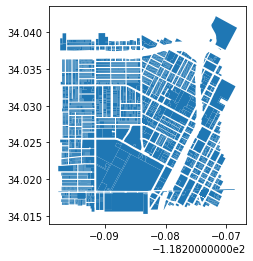

In [737]:
parcels_usc_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/LA_County_Parcels_usc.geojson'
parcels_usc_df = gpd.read_file(parcels_dir, na_values = ['masked'])
parcels_usc_df.plot()

Filter columns to reduce clutter

In [738]:
#lariac_usc_df.head()

In [739]:
# rename OBJECTID to avoid duplicate column names
lariac_usc_df.rename(columns={'OBJECTID':'lariac_id'}, inplace=True)
parcels_usc_df.rename(columns={'OBJECTID':'parcel_id'}, inplace=True)

In [740]:
# choose columns to keep
lariac_columns = ['lariac_id',
 'CODE',
 'BLD_ID',
 'HEIGHT',
 'ELEV',
 'DATE_',
 'STATUS',
 'AREA',
 'geometry']

parcels_columns = ['parcel_id',
 'AIN',
 'APN',
 'UseType',
 'UseDescrip',
 'DesignType',
 'CENTER_LAT',
 'CENTER_LON',
 'CENTER_X',
 'CENTER_Y',
 'LAT_LON',
 'ShapeSTAre',
 'ShapeSTLen',
 'geometry']

In [741]:
# keep only columns listed above
lariac_usc_df = lariac_usc_df[lariac_columns]
parcels_usc_df = parcels_usc_df[parcels_columns]

In [742]:
# calculate shape area from geometry in units of meters squared
lariac_usc_df['shape_area_whole'] = lariac_usc_df.to_crs('epsg:3857').geometry.area

In [743]:
# delete courtyards, keep only buildings
lariac_usc_df.drop(lariac_usc_df[lariac_usc_df['CODE']=='Courtyard'].index, inplace=True)

In [479]:
#lariac_usc_df.shape

(13890, 10)

In [481]:
#len(lariac_usc_df['lariac_id'].unique())

13890

In [758]:
#lariac_usc_df.explore()

## Download LA Times Mapping neighborhoods data

<AxesSubplot:>

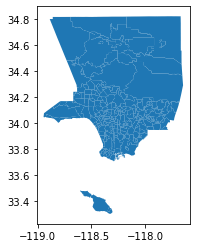

In [56]:
# source: https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr
neighborhoods_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/la_bound_nbhd.geojson'
neighborhoods = gpd.read_file(neighborhoods_dir)
neighborhoods.plot()

In [57]:
neighborhoods.dtypes

external_i      object
name            object
location        object
latitude        object
slug_1          object
sqmi            object
display_na      object
set             object
slug            object
longitude       object
name_1          object
kind            object
type            object
geometry      geometry
dtype: object

In [58]:
# county_boundary_url = 'https://opendata.arcgis.com/datasets/10f1e37c065347e693cf4e8ee753c09b_15.geojson'
# county_boundary = gpd.read_file(county_boundary_url)
# county_boundary.plot()

In [59]:
# This file contains neighborhoods in Orange County as well. Used file saved on laptop downloaded from website (See above).
# url = 'https://github.com/datadesk/mapping-la-data/raw/main/geojson/la-county-neighborhoods-v6.geojson'
# #file = requests.get(url)
# neighborhoods = gpd.read_file(url)
# neighborhoods.head()

<AxesSubplot:>

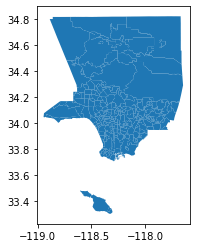

In [60]:
# plot boundaries of neighborhoods for visual check
neighborhoods.plot()

In [61]:
neighborhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [62]:
# Remove Catalina Island (including Avalon) from dataframe
catalina_index = neighborhoods.query('name.str.contains("Catalina") | name.str.contains("Avalon")').index
neighborhoods.drop(catalina_index, inplace=True)

Empty GeoDataFrame
Columns: [external_i, name, location, latitude, slug_1, sqmi, display_na, set, slug, longitude, name_1, kind, type, geometry]
Index: []


<AxesSubplot:>

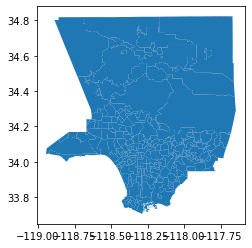

In [63]:
# Check that it was removed
print(neighborhoods.query('name.str.contains("Catalina") | name.str.contains("Avalon")'))
neighborhoods.plot()

In [64]:
#neighborhoods.explore()

## Merge neighborhood boundaries and Energy Atlas data

In [65]:
neighborhoods.head()

external_i             name  \
0            acton            Acton   
1  adams-normandie  Adams-Normandie   
2     agoura-hills     Agoura Hills   
3       agua-dulce       Agua Dulce   
4         alhambra         Alhambra   

                                        location             latitude slug_1  \
0  POINT(34.497355239240846 -118.16981019229348)  -118.16981019229348   None   
1  POINT(34.031461499124156 -118.30020800000011)  -118.30020800000011   None   
2  POINT(34.146736499122795 -118.75988450000015)  -118.75988450000015   None   
3   POINT(34.504926999796837 -118.3171036690717)   -118.3171036690717   None   
4  POINT(34.085538999123571 -118.13651200000021)  -118.13651200000021   None   

             sqmi                                         display_na  \
0   39.3391089485           Acton L.A. County Neighborhood (Current)   
1  0.805350187789  Adams-Normandie L.A. County Neighborhood (Curr...   
2   8.14676029818    Agoura Hills L.A. County Neighborhood (Current)   
3   31.4626319451      Agua Dulce L.A. County Neighborhood (Current)   
4   7.62381430605        Alhambra L.A. County Neighborhood (Current)   

                                   set             slug           longitude  \
0  L.A. County Neighborhoods (Current)            acton  34.497355239240846   
1  L.A. County Neighborhoods (Current)  adams-normandie  34.031461499124156   
2  L.A. County Neighborhoods (Current)     agoura-hills  34.146736499122795   
3  L.A. County Neighborhoods (Current)       agua-dulce  34.504926999796837   
4  L.A. County Neighborhoods (Current)         alhambra  34.085538999123571   

  name_1                                kind                 type  \
0   None  L.A. County Neighborhood (Current)  unincorporated-area   
1   None  L.A. County Neighborhood (Current)    segment-of-a-city   
2   None  L.A. County Neighborhood (Current)      standalone-city   
3   None  L.A. County Neighborhood (Current)  unincorporated-area   
4   None  L.A. County Neighborhood (Current)      standalone-city   

                                            geometry  
0  MULTIPOLYGON (((-118.20262 34.53899, -118.1894...  
1  MULTIPOLYGON (((-118.30901 34.03741, -118.3004...  
2  MULTIPOLYGON (((-118.76193 34.16820, -118.7263...  
3  MULTIPOLYGON (((-118.25468 34.55830, -118.2555...  
4  MULTIPOLYGON (((-118.12175 34.10504, -118.1168...

In [66]:
usage_bld_btu

geo_id       sqft         usage     usage_med  usage_med_sqft  \
0             cities_1     1253.0           NaN           NaN             NaN   
1             cities_1  4820002.0  3.079439e+11  5.522517e+08      46351.2600   
2             cities_1  8916603.0  3.715327e+11  7.530818e+07      34141.0256   
3             cities_1   735816.0           NaN           NaN             NaN   
4             cities_1   100192.0           NaN           NaN             NaN   
...                ...        ...           ...           ...             ...   
5767  neighborhoods_99    30060.0           NaN           NaN             NaN   
5768  neighborhoods_99        0.0           NaN           NaN             NaN   
5769  neighborhoods_99  3452091.0  1.350114e+11  9.211511e+07      35663.1742   
5770  neighborhoods_99  1525718.0  6.178565e+10  7.913064e+07      37415.2632   
5771  neighborhoods_99        NaN           NaN           NaN             NaN   

                usetype  year  pct_elec    pct_ng          name     pop  \
0           agriculture  2016       NaN       NaN  agoura hills     NaN   
1            commercial  2016  0.729374  0.270626  agoura hills     NaN   
2                 condo  2016  0.401412  0.598588  agoura hills     NaN   
3            industrial  2016       NaN       NaN  agoura hills     NaN   
4         institutional  2016       NaN       NaN  agoura hills     NaN   
...                 ...   ...       ...       ...           ...     ...   
5767  residential_other  2016       NaN       NaN       carthay     NaN   
5768  residential_uncat  2016       NaN       NaN       carthay     NaN   
5769          res_total  2016  0.325581  0.674419       carthay  5201.0   
5770      single_family  2016  0.352719  0.647281       carthay     NaN   
5771              uncat  2016       NaN       NaN       carthay     NaN   

      usage_percap  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
5767           NaN  
5768           NaN  
5769  2.595873e+07  
5770           NaN  
5771           NaN  

[5772 rows x 12 columns]

In [67]:
neighborhoods_lower = neighborhoods.copy()
neighborhoods_lower['name'] = neighborhoods_lower['name'].str.lower()
neighborhoods_lower.head()

external_i             name  \
0            acton            acton   
1  adams-normandie  adams-normandie   
2     agoura-hills     agoura hills   
3       agua-dulce       agua dulce   
4         alhambra         alhambra   

                                        location             latitude slug_1  \
0  POINT(34.497355239240846 -118.16981019229348)  -118.16981019229348   None   
1  POINT(34.031461499124156 -118.30020800000011)  -118.30020800000011   None   
2  POINT(34.146736499122795 -118.75988450000015)  -118.75988450000015   None   
3   POINT(34.504926999796837 -118.3171036690717)   -118.3171036690717   None   
4  POINT(34.085538999123571 -118.13651200000021)  -118.13651200000021   None   

             sqmi                                         display_na  \
0   39.3391089485           Acton L.A. County Neighborhood (Current)   
1  0.805350187789  Adams-Normandie L.A. County Neighborhood (Curr...   
2   8.14676029818    Agoura Hills L.A. County Neighborhood (Current)   
3   31.4626319451      Agua Dulce L.A. County Neighborhood (Current)   
4   7.62381430605        Alhambra L.A. County Neighborhood (Current)   

                                   set             slug           longitude  \
0  L.A. County Neighborhoods (Current)            acton  34.497355239240846   
1  L.A. County Neighborhoods (Current)  adams-normandie  34.031461499124156   
2  L.A. County Neighborhoods (Current)     agoura-hills  34.146736499122795   
3  L.A. County Neighborhoods (Current)       agua-dulce  34.504926999796837   
4  L.A. County Neighborhoods (Current)         alhambra  34.085538999123571   

  name_1                                kind                 type  \
0   None  L.A. County Neighborhood (Current)  unincorporated-area   
1   None  L.A. County Neighborhood (Current)    segment-of-a-city   
2   None  L.A. County Neighborhood (Current)      standalone-city   
3   None  L.A. County Neighborhood (Current)  unincorporated-area   
4   None  L.A. County Neighborhood (Current)      standalone-city   

                                            geometry  
0  MULTIPOLYGON (((-118.20262 34.53899, -118.1894...  
1  MULTIPOLYGON (((-118.30901 34.03741, -118.3004...  
2  MULTIPOLYGON (((-118.76193 34.16820, -118.7263...  
3  MULTIPOLYGON (((-118.25468 34.55830, -118.2555...  
4  MULTIPOLYGON (((-118.12175 34.10504, -118.1168...

In [392]:
usage_bld = neighborhoods_lower.merge(usage_bld_btu, on='name')
usage_bld.columns

Index(['external_i', 'name', 'location', 'latitude', 'slug_1', 'sqmi',
       'display_na', 'set', 'slug', 'longitude', 'name_1', 'kind', 'type',
       'geometry', 'geo_id', 'sqft', 'usage', 'usage_med', 'usage_med_sqft',
       'usetype', 'year', 'pct_elec', 'pct_ng', 'pop', 'usage_percap'],
      dtype='object')

In [393]:
# clean up dataframe, drop unnecessary columns
cols_drop = ['external_i','slug_1','display_na', 'set', 'name_1']
usage_bld.drop(cols_drop, axis=1, inplace=True)
usage_bld.columns

Index(['name', 'location', 'latitude', 'sqmi', 'slug', 'longitude', 'kind',
       'type', 'geometry', 'geo_id', 'sqft', 'usage', 'usage_med',
       'usage_med_sqft', 'usetype', 'year', 'pct_elec', 'pct_ng', 'pop',
       'usage_percap'],
      dtype='object')

In [394]:
# add column for usage in units of Joules (1 btu = 1055.06 joules)
usage_bld['usage_joules'] = usage_bld['usage']*1055.06

<AxesSubplot:>

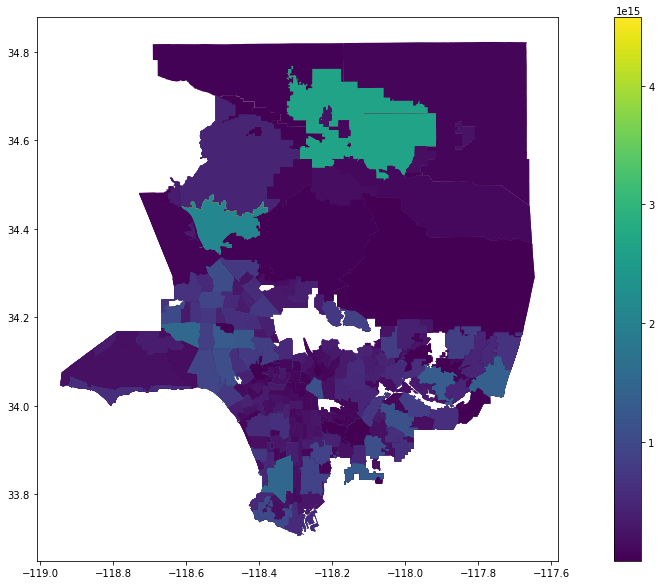

In [395]:
usage_bld.plot(column='usage_joules', legend=True, figsize=(20,10))

## Descriptive analysis of Energy Atlas data

In [72]:
# How many different usetype categories?
usage_bld_btu['usetype'].unique()

array(['agriculture', 'commercial', 'condo', 'industrial',
       'institutional', 'multi_family', 'other', 'residential_other',
       'residential_uncat', 'res_total', 'single_family', 'uncat'],
      dtype=object)

In [73]:
# subset only neighborhood-aggregated records
usage_bld_btu_neighborhoods = usage_bld_btu.loc[usage_bld_btu['geo_id'].str.contains('neighborhoods')].copy()
usage_bld_btu_neighborhoods

geo_id       sqft         usage     usage_med  \
2508  neighborhoods_100        NaN           NaN           NaN   
2509  neighborhoods_100   554997.0           NaN           NaN   
2510  neighborhoods_100    50416.0  1.745402e+10  1.677837e+08   
2511  neighborhoods_100    44121.0           NaN           NaN   
2512  neighborhoods_100    17252.0           NaN           NaN   
...                 ...        ...           ...           ...   
5767   neighborhoods_99    30060.0           NaN           NaN   
5768   neighborhoods_99        0.0           NaN           NaN   
5769   neighborhoods_99  3452091.0  1.350114e+11  9.211511e+07   
5770   neighborhoods_99  1525718.0  6.178565e+10  7.913064e+07   
5771   neighborhoods_99        NaN           NaN           NaN   

      usage_med_sqft            usetype  year  pct_elec    pct_ng     name  \
2508             NaN        agriculture  2016       NaN       NaN  castaic   
2509             NaN         commercial  2016       NaN       NaN  castaic   
2510      99221.5579              condo  2016  0.435955  0.564045  castaic   
2511             NaN         industrial  2016       NaN       NaN  castaic   
2512             NaN      institutional  2016       NaN       NaN  castaic   
...              ...                ...   ...       ...       ...      ...   
5767             NaN  residential_other  2016       NaN       NaN  carthay   
5768             NaN  residential_uncat  2016       NaN       NaN  carthay   
5769      35663.1742          res_total  2016  0.325581  0.674419  carthay   
5770      37415.2632      single_family  2016  0.352719  0.647281  carthay   
5771             NaN              uncat  2016       NaN       NaN  carthay   

         pop  usage_percap  
2508     NaN           NaN  
2509     NaN           NaN  
2510     NaN           NaN  
2511     NaN           NaN  
2512     NaN           NaN  
...      ...           ...  
5767     NaN           NaN  
5768     NaN           NaN  
5769  5201.0  2.595873e+07  
5770     NaN           NaN  
5771     NaN           NaN  

[3264 rows x 12 columns]

In [74]:
# How many unique neighborhoods?
len(usage_bld_btu_neighborhoods['geo_id'].unique())

272

In [75]:
# further subset for only residential
usage_bld_btu_neighborhoods_res = usage_bld_btu_neighborhoods.loc[usage_bld_btu_neighborhoods['usetype'] == 'res_total'].copy()
usage_bld_btu_neighborhoods_res

geo_id        sqft         usage     usage_med  \
2517  neighborhoods_100  10257155.0  4.076383e+11  6.796309e+07   
2529  neighborhoods_101  16985227.0  7.236221e+11  7.088365e+07   
2541  neighborhoods_102   7467333.0  3.477981e+11  6.447685e+07   
2553  neighborhoods_103   1691063.0  3.436476e+11  8.125534e+07   
2565  neighborhoods_104         NaN           NaN           NaN   
...                 ...         ...           ...           ...   
5721   neighborhoods_95         NaN           NaN           NaN   
5733   neighborhoods_96  19994907.0  9.702669e+11  9.399458e+07   
5745   neighborhoods_97  18630293.0  9.789736e+11  6.674304e+07   
5757   neighborhoods_98  30620822.0  1.376155e+12  4.847913e+07   
5769   neighborhoods_99   3452091.0  1.350114e+11  9.211511e+07   

      usage_med_sqft    usetype  year  pct_elec    pct_ng             name  \
2517      34019.6952  res_total  2016  0.420110  0.579890          castaic   
2529      27792.0387  res_total  2016  0.431834  0.568166  castaic canyons   
2541      42876.8815  res_total  2016  0.306654  0.693346  central-alameda   
2553      39514.2308  res_total  2016  0.379314  0.620686     century city   
2565             NaN  res_total  2016       NaN       NaN         cerritos   
...              ...        ...   ...       ...       ...              ...   
5721             NaN  res_total  2016       NaN       NaN          burbank   
5733      34430.9786  res_total  2016  0.405001  0.594999        calabasas   
5745      44255.3542  res_total  2016  0.421667  0.578333      canoga park   
5757      32486.7605  res_total  2016  0.353819  0.646181           carson   
5769      35663.1742  res_total  2016  0.325581  0.674419          carthay   

           pop  usage_percap  
2517   16843.0  2.420224e+07  
2529   46516.0  1.555641e+07  
2541   43628.0  7.971901e+06  
2553    5516.0  6.230015e+07  
2565   49956.0           NaN  
...        ...           ...  
5721  104565.0           NaN  
5733   25656.0  3.781832e+07  
5745   61801.0  1.584074e+07  
5757   92200.0  1.492576e+07  
5769    5201.0  2.595873e+07  

[272 rows x 12 columns]

In [76]:
print(usage_bld_btu_neighborhoods_res._is_copy)

None


In [77]:
# testing SettingWithCopyWarning with test df
df = pd.DataFrame({'A': ['1', '2', 'NaN'], 'B': ['1', 'NaN', '3'], 'C': ['1', '2', '3']})
cols = df.columns.drop(['C'])
df.loc[:, cols] = df[cols].apply(pd.to_numeric, errors = 'coerce')
df

A    B  C
0  1.0  1.0  1
1  2.0  NaN  2
2  NaN  3.0  3

In [78]:
# convert appropriate columns to numeric
cols = usage_bld_btu_neighborhoods_res.columns.drop(['geo_id', 'usetype', 'name'])
usage_bld_btu_neighborhoods_res.loc[:,cols] = usage_bld_btu_neighborhoods_res[cols].apply(pd.to_numeric, errors = 'coerce')
usage_bld_btu_neighborhoods_res.dtypes

geo_id             object
sqft              float64
usage             float64
usage_med         float64
usage_med_sqft    float64
usetype            object
year                int64
pct_elec          float64
pct_ng            float64
name               object
pop               float64
usage_percap      float64
dtype: object

<AxesSubplot:ylabel='Frequency'>

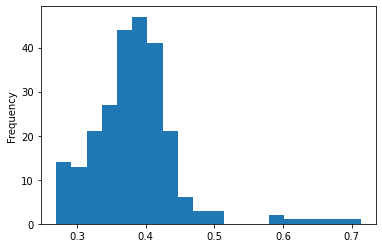

In [79]:
# distribution of pct_elec
# usage_bld_btu_neighborhoods_res['pct_elec'] = pd.to_numeric(usage_bld_btu_neighborhoods_res['pct_elec'])
usage_bld_btu_neighborhoods_res['pct_elec'].plot.hist(bins = 20) 

<AxesSubplot:ylabel='Frequency'>

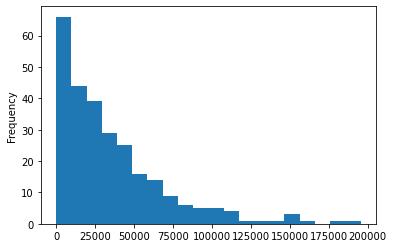

In [80]:
# distribution of pop
usage_bld_btu_neighborhoods_res['pop'].plot.hist(bins = 20) 

<AxesSubplot:ylabel='Frequency'>

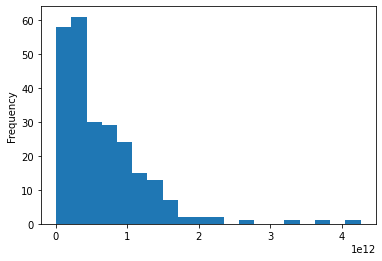

In [81]:
# distribution of usage
usage_bld_btu_neighborhoods_res['usage'].plot.hist(bins = 20) 

<AxesSubplot:ylabel='Frequency'>

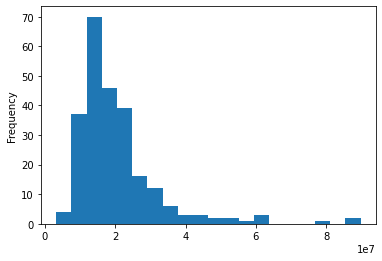

In [82]:
# distribution of usage per capita
usage_bld_btu_neighborhoods_res['usage_percap'].plot.hist(bins = 20) 

## Create 2d grid

In [130]:
"""
example references:
https://james-brennan.github.io/posts/fast_gridding_geopandas/
https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python
"""

# create grid that covers the extent of LA County, set at 'X' m resolution
xmin, ymin, xmax, ymax= neighborhoods.total_bounds

# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)
to_original_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((xmin, ymin))
ne = shapely.geometry.Point((xmax, ymax))

stepsize = 1000 # grid resolution in meters

# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE



In [133]:
print(xmin, ymin, xmax, ymax)

-118.94486418867147 33.70453798214502 -117.64560400000032 34.82316790057429


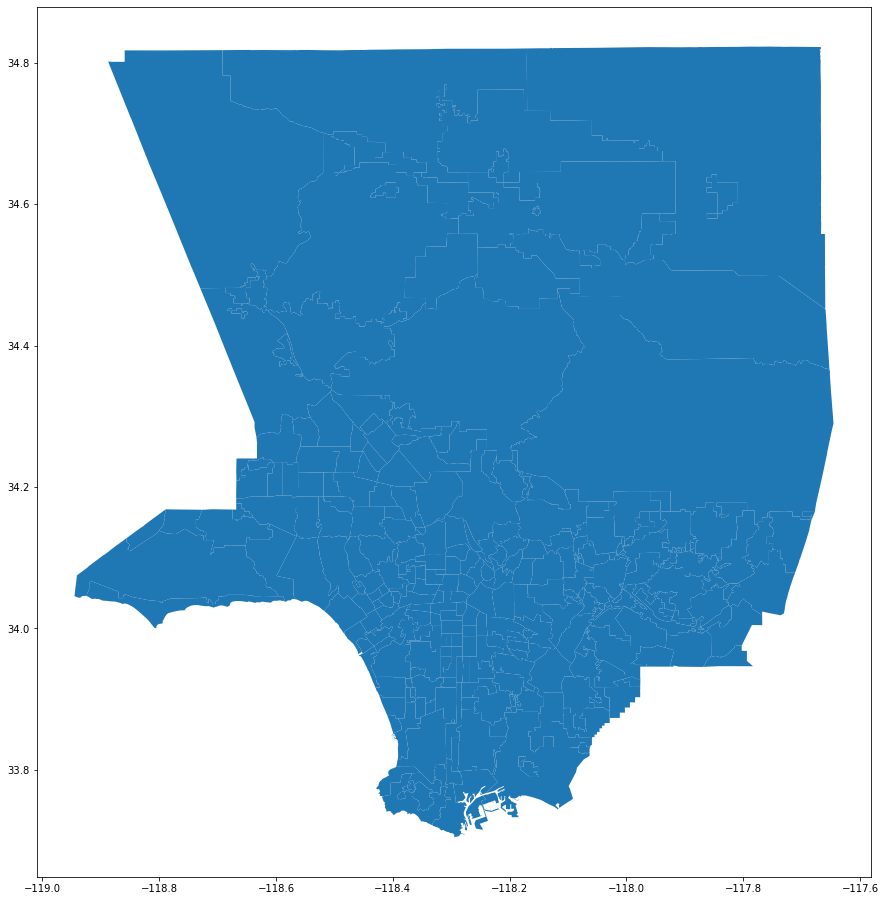

In [132]:
# Iterate over 2D area
grid_cells = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        x1 = x + stepsize
        y1 = y + stepsize
        cell = shapely.geometry.box(x, y, x1, y1)
        grid_cells.append(cell)
        y += stepsize
    x += stepsize


ah_grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='epsg:3857')
ah_grid = ah_grid.to_crs('epsg:4326')

ax = neighborhoods.plot(figsize=(24, 16))
plt.autoscale(False)
#ah_grid.plot(ax=ax, facecolor="none", edgecolor='grey')

## Anthropogenic heat flux from residential buildings

### Test case 1: University Park neighborhood

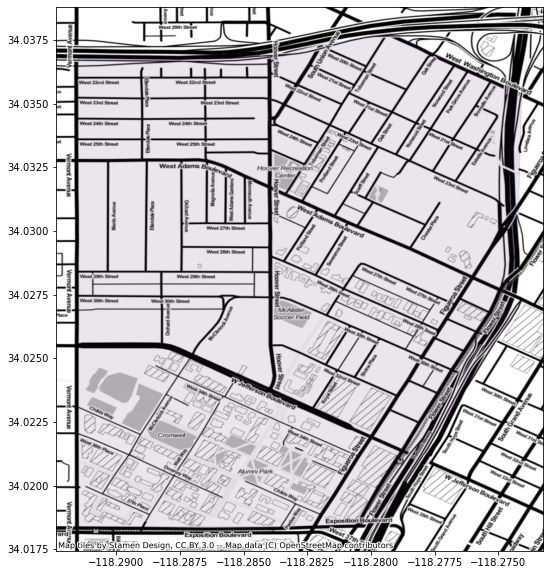

In [714]:
# get usage for university park neighborhood only
usage_usc = usage_bld[(usage_bld['name'] == 'university park') & (usage_bld['usetype'] == 'res_total')]
#usage_usc = usage_bld[usage_bld['usetype'] == 'res_total']
ax = usage_usc.plot(figsize=(10,10), column = 'usage_joules', alpha=0.1, edgecolor='k')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
#ax.annotate(usage_usc.iloc[0].usage_joules, xy=[pd.to_numeric(top_row['latitude']), pd.to_numeric(top_row['longitude'])])
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=usage_bld.crs) # notice the crs must match between basemap and data

<AxesSubplot:>

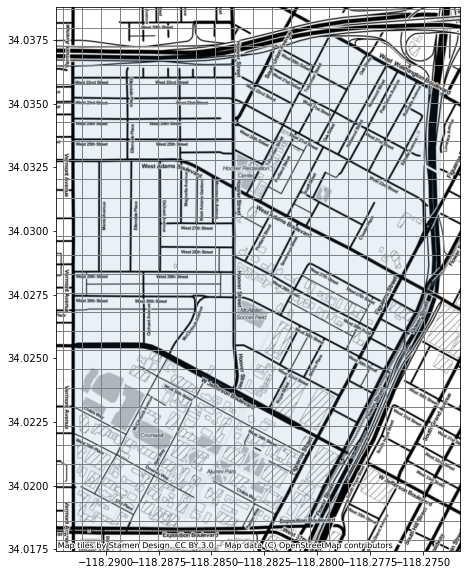

In [715]:
# create 2d grid
"""
example references:
https://james-brennan.github.io/posts/fast_gridding_geopandas/
https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python
"""

# create grid that covers the extent of LA County, set at 'X' m resolution
xmin, ymin, xmax, ymax = usage_usc.total_bounds

# create a little buffer for extent
xmin = xmin - 0.005
ymin = ymin - 0.005
xmax = xmax + 0.005
ymax = ymax + 0.005

# Set up transformers, EPSG:3857 is metric, same as EPSG:900913
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)
to_original_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((xmin, ymin))
ne = shapely.geometry.Point((xmax, ymax))

stepsize = 100 # grid resolution in meters

# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE

# Iterate over 2D area
grid_cells = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        x1 = x + stepsize
        y1 = y + stepsize
        cell = shapely.geometry.box(x, y, x1, y1)
        grid_cells.append(cell)
        y += stepsize
    x += stepsize


ah_grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='epsg:3857')
ah_grid = ah_grid.to_crs('epsg:4326')

ax = usage_usc.plot(figsize=(10,10), alpha=0.1, edgecolor='k')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=usage_bld.crs) # notice the crs must match between basemap and data
ah_grid.plot(ax=ax, facecolor="none", edgecolor='grey')

<AxesSubplot:>

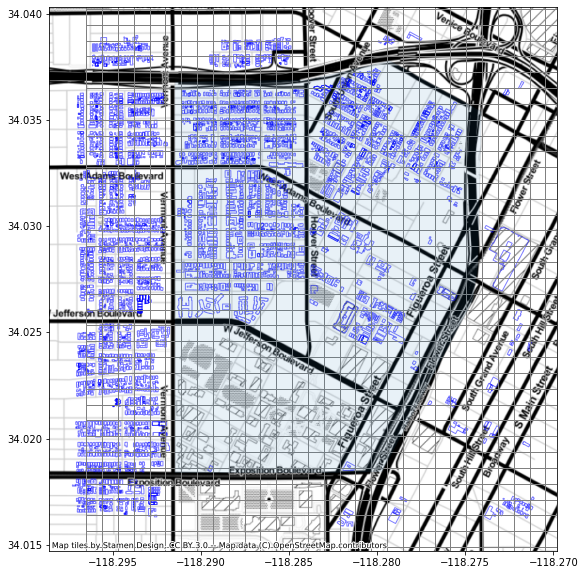

In [716]:
# spatial join LARIAC and parcels dataframe
parcels_usc_res_df = parcels_usc_df[parcels_usc_df['UseType'] == 'Residential'].copy() # filter for only residential
parcels_usc_res_df.drop_duplicates('geometry', inplace=True) # !!!REMOVE DUPLICATE PARCELS!!!
lariac_usc_merged_inner = gpd.sjoin(lariac_usc_df, parcels_usc_res_df, how='inner')

# plot to visualize
ax = lariac_usc_merged_inner.plot(figsize=(10,10), alpha=0.5, facecolor = 'none', edgecolor='blue')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
ah_grid.plot(ax=ax, facecolor="none", edgecolor='gray')
usage_usc.plot(ax=ax, alpha=0.1, edgecolor='k')

<AxesSubplot:>

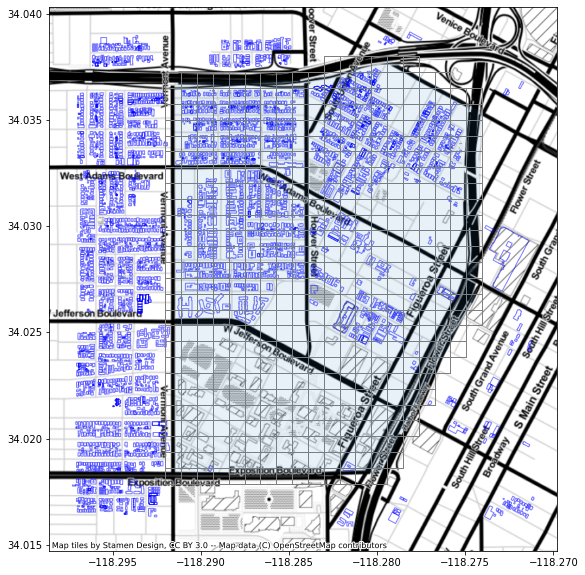

In [637]:
# spatial join the 2d grid and the neighborhood boundary
grid_usc = gpd.sjoin(ah_grid, usage_usc)
# plot to visualize
ax = lariac_usc_merged_inner.plot(figsize=(10,10), alpha=0.5, facecolor = 'none', edgecolor='blue')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
usage_usc.plot(ax=ax, alpha=0.1, edgecolor='k')

In [638]:
# drop columns with 'index_*'
grid_usc.drop(list(grid_usc.filter(regex = 'index_')), axis=1, inplace=True)
lariac_usc_merged_inner.drop(list(lariac_usc_merged_inner.filter(regex = 'index_')), axis=1, inplace=True)
# add extra geometry column to save grid geometry for spatial joins
grid_usc['grid_geometry'] = grid_usc.geometry
# make the index a column
grid_usc.reset_index(inplace=True)
# rename index to grid_cell_index
grid_usc.rename(columns={'index':'grid_cell_index'}, inplace=True)

In [639]:
grid_usc.head()

grid_cell_index                                           geometry  \
0              206  POLYGON ((-118.29112 34.01788, -118.29112 34.0...   
1              207  POLYGON ((-118.29112 34.01863, -118.29112 34.0...   
2              208  POLYGON ((-118.29112 34.01937, -118.29112 34.0...   
3              209  POLYGON ((-118.29112 34.02012, -118.29112 34.0...   
4              210  POLYGON ((-118.29112 34.02086, -118.29112 34.0...   

              name                                       location  \
0  university park  POINT(34.028113999124287 -118.28280750000005)   
1  university park  POINT(34.028113999124287 -118.28280750000005)   
2  university park  POINT(34.028113999124287 -118.28280750000005)   
3  university park  POINT(34.028113999124287 -118.28280750000005)   
4  university park  POINT(34.028113999124287 -118.28280750000005)   

              latitude           sqmi             slug           longitude  \
0  -118.28280750000005  1.16714354652  university-park  34.028113999124287   
1  -118.28280750000005  1.16714354652  university-park  34.028113999124287   
2  -118.28280750000005  1.16714354652  university-park  34.028113999124287   
3  -118.28280750000005  1.16714354652  university-park  34.028113999124287   
4  -118.28280750000005  1.16714354652  university-park  34.028113999124287   

                                 kind               type  ...     usage_med  \
0  L.A. County Neighborhood (Current)  segment-of-a-city  ...  9.962047e+07   
1  L.A. County Neighborhood (Current)  segment-of-a-city  ...  9.962047e+07   
2  L.A. County Neighborhood (Current)  segment-of-a-city  ...  9.962047e+07   
3  L.A. County Neighborhood (Current)  segment-of-a-city  ...  9.962047e+07   
4  L.A. County Neighborhood (Current)  segment-of-a-city  ...  9.962047e+07   

   usage_med_sqft    usetype  year  pct_elec    pct_ng      pop  usage_percap  \
0      34292.2159  res_total  2016  0.444748  0.555252  24834.0  1.015430e+07   
1      34292.2159  res_total  2016  0.444748  0.555252  24834.0  1.015430e+07   
2      34292.2159  res_total  2016  0.444748  0.555252  24834.0  1.015430e+07   
3      34292.2159  res_total  2016  0.444748  0.555252  24834.0  1.015430e+07   
4      34292.2159  res_total  2016  0.444748  0.555252  24834.0  1.015430e+07   

   usage_joules                                      grid_geometry  
0  2.660564e+14  POLYGON ((-118.29112 34.01788, -118.29112 34.0...  
1  2.660564e+14  POLYGON ((-118.29112 34.01863, -118.29112 34.0...  
2  2.660564e+14  POLYGON ((-118.29112 34.01937, -118.29112 34.0...  
3  2.660564e+14  POLYGON ((-118.29112 34.02012, -118.29112 34.0...  
4  2.660564e+14  POLYGON ((-118.29112 34.02086, -118.29112 34.0...  

[5 rows x 23 columns]

<AxesSubplot:>

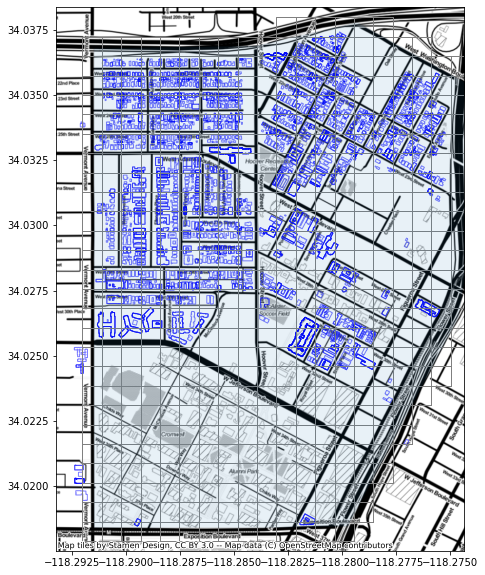

In [640]:
# spatial join buildings and grid (intersects)
buildings_usc_intersects = gpd.sjoin(lariac_usc_merged_inner, grid_usc, predicate='intersects')
# plot to visualize
ax = buildings_usc_intersects.plot(figsize=(10,10), alpha=0.5, facecolor = 'none', edgecolor='blue')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
usage_usc.plot(ax=ax, alpha=0.1, edgecolor='k')              

In [641]:
# # spatial join buildings and grid (within)
# buildings_usc_within = gpd.sjoin(lariac_usc_merged_inner, grid_usc, predicate='within')
# # plot to visualize
# ax = grid_usc.plot(figsize=(10,10), facecolor="none", edgecolor='blue')
# ax.get_xaxis().get_major_formatter().set_useOffset(False)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
# buildings_usc_within.plot(ax=ax, alpha=0.5, facecolor = 'yellow', edgecolor='red')
# usage_usc.plot(ax=ax, alpha=0.1, edgecolor='k')       

In [642]:
# # spatial join buildings and grid (Switch left/right order this time)
# grid_usc_intersects = gpd.sjoin(grid_usc, lariac_usc_merged_inner, predicate='intersects')
# # plot to visualize
# ax = grid_usc_intersects.plot(figsize=(10,10), alpha=0.5, facecolor = 'yellow', edgecolor='red')
# ax.get_xaxis().get_major_formatter().set_useOffset(False)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
# grid_usc.plot(ax=ax, facecolor="none", edgecolor='blue')
# usage_usc.plot(ax=ax, alpha=0.1, edgecolor='k')  

<AxesSubplot:>

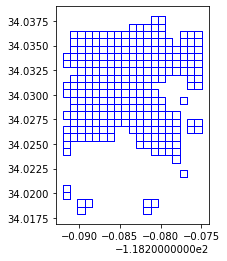

In [643]:
buildings_usc_intersects.grid_geometry.plot(facecolor="none", edgecolor='blue')

In [644]:
len(buildings_usc_intersects.grid_geometry.unique())

259

In [645]:
#testing overlay 
buildings_usc_overlay_intersection = lariac_usc_merged_inner.overlay(grid_usc, how='intersection')
# plot to visualize
#buildings_usc_overlay_intersection.explore()

In [646]:
# total building area in this neighborhood?
total_building_area_usc = buildings_usc_overlay_intersection['AREA'].sum()
total_building_area_usc

8672962.736312995

In [647]:
# calculate building volume and add as a new column
buildings_usc_overlay_intersection['VOLUME'] = buildings_usc_overlay_intersection['AREA']*buildings_usc_overlay_intersection['HEIGHT'] # units: cubic feet

In [648]:
#buildings_usc_overlay_intersection.shape

In [649]:
#len(buildings_usc_overlay_intersection['lariac_id'].unique())

In [650]:
# add column that describes the fraction of the whole building that segment represents
buildings_usc_overlay_intersection['building_fraction'] = buildings_usc_overlay_intersection.to_crs('epsg:3857').geometry.area/buildings_usc_overlay_intersection['shape_area_whole']
buildings_usc_overlay_intersection['VOLUME'] = buildings_usc_overlay_intersection['building_fraction']*buildings_usc_overlay_intersection['VOLUME']
#buildings_usc_overlay_intersection

In [651]:
# total building area in this neighborhood?
total_building_vol_usc = buildings_usc_overlay_intersection['VOLUME'].sum()
total_building_vol_usc

135613570.90212217

In [652]:
# df of total building volume in each grid cell
building_volume_df = buildings_usc_overlay_intersection[['grid_cell_index', 'VOLUME']]
volume_by_cell = building_volume_df.groupby('grid_cell_index').sum()
# make the index a column
volume_by_cell.reset_index(inplace=True)

In [653]:
# add cells with no buildings 
volume_by_cell_all = volume_by_cell.merge(grid_usc, how='outer') # outer join
volume_by_cell_all = volume_by_cell_all[['grid_cell_index','VOLUME','pct_elec','usage_joules','grid_geometry']] # only keep these columns
volume_by_cell_all.head()

grid_cell_index         VOLUME  pct_elec  usage_joules  \
0              208  383889.604946  0.444748  2.660564e+14   
1              209  190788.635726  0.444748  2.660564e+14   
2              214   32892.316677  0.444748  2.660564e+14   
3              215  199189.571702  0.444748  2.660564e+14   
4              216  162447.525434  0.444748  2.660564e+14   

                                       grid_geometry  
0  POLYGON ((-118.29112 34.01937, -118.29112 34.0...  
1  POLYGON ((-118.29112 34.02012, -118.29112 34.0...  
2  POLYGON ((-118.29112 34.02384, -118.29112 34.0...  
3  POLYGON ((-118.29112 34.02458, -118.29112 34.0...  
4  POLYGON ((-118.29112 34.02533, -118.29112 34.0...

In [654]:
# calculate volume-based weights and finally, the AHF
cell_area = stepsize**2 # area of single cell; stepsize is resolution in meters (defined above)
n_cells = len(grid_usc) # number of total cells in neighborhood
seconds_in_year = 3.154e+7
ahf = gpd.GeoDataFrame(volume_by_cell_all, geometry='grid_geometry')
ahf['VOLUME'] = ahf['VOLUME'].fillna(0)
ahf['vol_frac'] = ahf['VOLUME']/total_building_vol_usc
ahf['electricity_use'] = ahf['pct_elec']*ahf['usage_joules']*ahf['vol_frac']
ahf['ahf'] = ahf['electricity_use']/cell_area/seconds_in_year
ahf

grid_cell_index         VOLUME  pct_elec  usage_joules  \
0                208  383889.604946  0.444748  2.660564e+14   
1                209  190788.635726  0.444748  2.660564e+14   
2                214   32892.316677  0.444748  2.660564e+14   
3                215  199189.571702  0.444748  2.660564e+14   
4                216  162447.525434  0.444748  2.660564e+14   
..               ...            ...       ...           ...   
485              986       0.000000  0.444748  2.660564e+14   
486              987       0.000000  0.444748  2.660564e+14   
487              988       0.000000  0.444748  2.660564e+14   
488              989       0.000000  0.444748  2.660564e+14   
489              990       0.000000  0.444748  2.660564e+14   

                                         grid_geometry  vol_frac  \
0    POLYGON ((-118.29112 34.01937, -118.29112 34.0...  0.002831   
1    POLYGON ((-118.29112 34.02012, -118.29112 34.0...  0.001407   
2    POLYGON ((-118.29112 34.02384, -118.29112 34.0...  0.000243   
3    POLYGON ((-118.29112 34.02458, -118.29112 34.0...  0.001469   
4    POLYGON ((-118.29112 34.02533, -118.29112 34.0...  0.001198   
..                                                 ...       ...   
485  POLYGON ((-118.27405 34.03277, -118.27405 34.0...  0.000000   
486  POLYGON ((-118.27405 34.03352, -118.27405 34.0...  0.000000   
487  POLYGON ((-118.27405 34.03426, -118.27405 34.0...  0.000000   
488  POLYGON ((-118.27405 34.03501, -118.27405 34.0...  0.000000   
489  POLYGON ((-118.27405 34.03575, -118.27405 34.0...  0.000000   

     electricity_use       ahf  
0       3.349587e+11  1.062012  
1       1.664706e+11  0.527808  
2       2.869984e+10  0.090995  
3       1.738007e+11  0.551049  
4       1.417418e+11  0.449403  
..               ...       ...  
485     0.000000e+00  0.000000  
486     0.000000e+00  0.000000  
487     0.000000e+00  0.000000  
488     0.000000e+00  0.000000  
489     0.000000e+00  0.000000  

[490 rows x 8 columns]

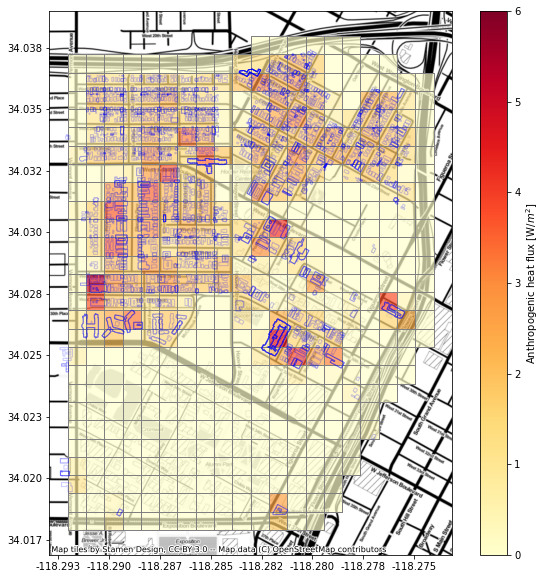

In [655]:
# plot to visualize
ax = ahf.plot(figsize=(10,10), column='ahf', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_intersects.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [656]:
# plot AHF with naive averaging (i.e., no building volume weights)
ahf['electricity_use_naive'] = (ahf['pct_elec']*ahf['usage_joules'])/n_cells
ahf['ahf_naive'] = ahf['electricity_use_naive']/cell_area/seconds_in_year

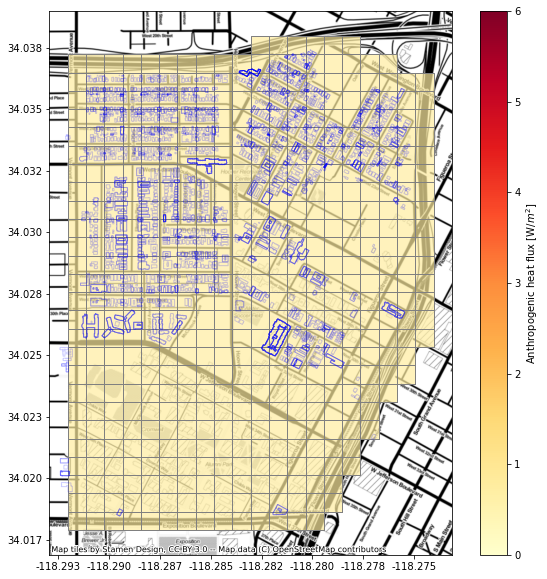

In [657]:
# plot to visualize
ax = ahf.plot(figsize=(10,10), column='ahf_naive', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6,legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_intersects.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

### Test case 2: University Park and Adams-Normandie

In [747]:
# create mask for two neighborhoods
neighborhoods_2 = neighborhoods[(neighborhoods['name']=='University Park') | (neighborhoods['name']=='Adams-Normandie')]
neighborhoods_2

external_i             name  \
1    adams-normandie  Adams-Normandie   
237  university-park  University Park   

                                          location             latitude  \
1    POINT(34.031461499124156 -118.30020800000011)  -118.30020800000011   
237  POINT(34.028113999124287 -118.28280750000005)  -118.28280750000005   

    slug_1            sqmi                                         display_na  \
1     None  0.805350187789  Adams-Normandie L.A. County Neighborhood (Curr...   
237   None   1.16714354652  University Park L.A. County Neighborhood (Curr...   

                                     set             slug           longitude  \
1    L.A. County Neighborhoods (Current)  adams-normandie  34.031461499124156   
237  L.A. County Neighborhoods (Current)  university-park  34.028113999124287   

    name_1                                kind               type  \
1     None  L.A. County Neighborhood (Current)  segment-of-a-city   
237   None  L.A. County Neighborhood (Current)  segment-of-a-city   

                                              geometry  
1    MULTIPOLYGON (((-118.30901 34.03741, -118.3004...  
237  MULTIPOLYGON (((-118.28282 34.01842, -118.2915...

CPU times: user 1min 29s, sys: 2.11 s, total: 1min 31s
Wall time: 1min 35s


<AxesSubplot:>

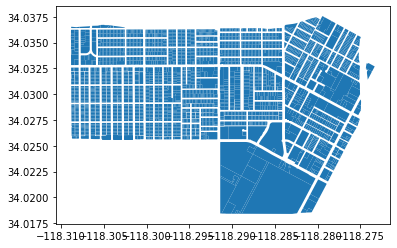

In [748]:
%%time
# load subset of parcels using mask                              
parcels_2_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/LA_County_Parcels-shp.zip'
parcels_2_df = gpd.read_file(parcels_2_dir, na_values = ['masked'], mask = neighborhoods_2)
parcels_2_df.plot()

In [750]:
%%time
# load subset of buildings using mask                         
lariac_2_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017.geojson'
lariac_2_df = gpd.read_file(lariac_2_dir)#, mask = neighborhoods_2)

CPU times: user 6min 34s, sys: 29.2 s, total: 7min 4s
Wall time: 7min 29s


In [757]:
%%time
# testing load of lariac data in gdb format                        
lariac_2_dir = '/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017.gdb'
lariac_2_df = gpd.read_file(lariac_2_dir)#, mask = neighborhoods_2)

CPU times: user 3min 59s, sys: 1min 26s, total: 5min 25s
Wall time: 7min 19s


In [753]:
# convert to feather 
geofeather.to_geofeather(lariac_2_df, '/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017.feather')

In [754]:
%%time
# read feather file
lariac_all_df = geofeather.from_geofeather('/Users/josephko/USC/Research/Anthropogenic Heat/lariac/Countywide_Building_Outlines_2017.feather')

CPU times: user 1min 13s, sys: 8.4 s, total: 1min 22s
Wall time: 1min 32s


In [756]:
lariac_all_df.tail()

OBJECTID      CODE        BLD_ID   HEIGHT         ELEV   SOURCE  \
3262635   3262636  Building  201700194794  18.3300  3643.940000  LARIAC5   
3262636   3262637  Building  201700194795  13.9250  3150.420684  LARIAC5   
3262637   3262638  Building  201700194796  20.2400  3060.570000  LARIAC5   
3262638   3262639  Building  201700194797  15.6000  3332.572777  LARIAC5   
3262639   3262640  Building  201700194798  11.9366  3310.017776  LARIAC5   

        DATE_    STATUS     OLD_BLD_ID         AREA  SHAPE_Length  \
3262635  2017  Modified   528284985731  3454.282781      0.000821   
3262636  2017       New           None   307.492951      0.000213   
3262637  2017  Modified  2014175190000  9163.545106      0.001727   
3262638  2017       New           None   314.902875      0.000222   
3262639  2017       New           None   397.561784      0.000242   

           SHAPE_Area                                           geometry  
3262635  3.148455e-08  MULTIPOLYGON (((-118.11071 34.44893, -118.1106...  
3262636  2.802999e-09  MULTIPOLYGON (((-118.16682 34.45817, -118.1668...  
3262637  8.353382e-08  MULTIPOLYGON (((-118.16446 34.46047, -118.1644...  
3262638  2.871037e-09  MULTIPOLYGON (((-118.02339 34.47245, -118.0234...  
3262639  3.624889e-09  MULTIPOLYGON (((-118.02454 34.47810, -118.0246...

<AxesSubplot:>

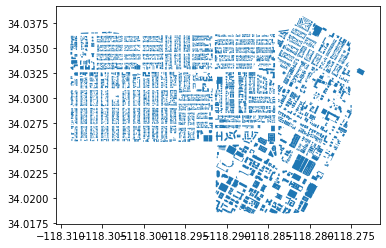

In [732]:
lariac_2_df.plot()

In [745]:
# rename OBJECTID to avoid duplicate column names
lariac_2_df.rename(columns={'OBJECTID':'lariac_id'}, inplace=True)
parcels_2_df.rename(columns={'OBJECTID':'parcel_id'}, inplace=True)

# keep only columns listed above
lariac_2_df = lariac_2_df[lariac_columns].copy()
parcels_2_df = parcels_2_df[parcels_columns].copy()

# calculate shape area from geometry in units of meters squared
lariac_2_df['shape_area_whole'] = lariac_2_df.to_crs('epsg:3857').geometry.area

# delete courtyards, keep only buildings
lariac_2_df.drop(lariac_2_df[lariac_2_df['CODE']=='Courtyard'].index, inplace=True)

In [ ]:
# get usage for university park neighborhood only
usage_usc = usage_bld[((usage_bld['name'] == 'adams-normandie') |
                      (usage_bld['name'] == 'university park')) &
                      (usage_bld['usetype'] == 'res_total')]
#usage_usc = usage_bld[usage_bld['usetype'] == 'res_total']
ax = usage_usc.plot(figsize=(10,10), column = 'usage_joules', alpha=0.1, edgecolor='k')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
#ax.annotate(usage_usc.iloc[0].usage_joules, xy=[pd.to_numeric(top_row['latitude']), pd.to_numeric(top_row['longitude'])])
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=usage_bld.crs) # notice the crs must match between basemap and data

## Anthropogenic heat flux from commercial buildings

### Proof of concept: University Park neighborhood

In [690]:
usage_bld['usetype'].unique()

array(['agriculture', 'commercial', 'condo', 'industrial',
       'institutional', 'multi_family', 'other', 'residential_other',
       'residential_uncat', 'res_total', 'single_family', 'uncat'],
      dtype=object)

In [691]:
# get usage for university park neighborhood only
usage_usc_com = usage_bld[(usage_bld['name'] == 'university park') & (usage_bld['usetype'] == 'commercial')]

In [701]:
usage_usc_com.head()

name                                       location  \
3769  university park  POINT(34.028113999124287 -118.28280750000005)   

                 latitude           sqmi             slug           longitude  \
3769  -118.28280750000005  1.16714354652  university-park  34.028113999124287   

                                    kind               type  \
3769  L.A. County Neighborhood (Current)  segment-of-a-city   

                                               geometry             geo_id  \
3769  MULTIPOLYGON (((-118.28282 34.01842, -118.2915...  neighborhoods_296   

      ...  usage  usage_med  usage_med_sqft     usetype  year  pct_elec  \
3769  ...    NaN        NaN             NaN  commercial  2016       NaN   

      pct_ng  pop  usage_percap  usage_joules  
3769     NaN  NaN           NaN           NaN  

[1 rows x 21 columns]

<AxesSubplot:>

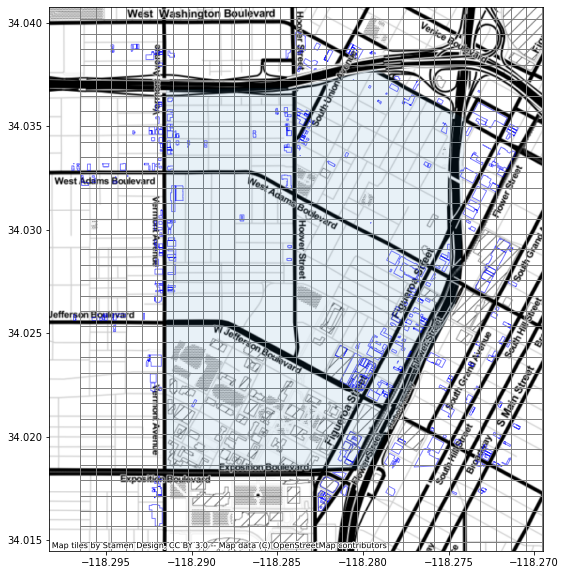

In [692]:
# spatial join LARIAC and parcels dataframe
parcels_usc_com_df = parcels_usc_df[parcels_usc_df['UseType'] == 'Commercial'].copy() # filter for only commercial
parcels_usc_com_df.drop_duplicates('geometry', inplace=True) # !!!REMOVE DUPLICATE PARCELS!!!
#lariac_usc_merged_inner_com = gpd.sjoin(lariac_usc_df, parcels_usc_com_df, how='inner')
lariac_usc_merged_inner_com = lariac_usc_df.overlay(parcels_usc_com_df, how='intersection')

# spatial join the 2d grid and the neighborhood boundary
grid_usc_com = gpd.sjoin(ah_grid, usage_usc_com)

# plot to visualize
ax = lariac_usc_merged_inner_com.plot(figsize=(10,10), alpha=0.5, facecolor = 'none', edgecolor='blue')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
ah_grid.plot(ax=ax, facecolor="none", edgecolor='gray')
usage_usc_com.plot(ax=ax, alpha=0.1, edgecolor='k')

In [693]:
# drop columns with 'index_*'
lariac_usc_merged_inner_com.drop(list(lariac_usc_merged_inner_com.filter(regex = 'index_')), axis=1, inplace=True)
grid_usc_com.drop(list(grid_usc.filter(regex = 'index_')), axis=1, inplace=True)
# add extra geometry column to save grid geometry for spatial joins
grid_usc_com['grid_geometry'] = grid_usc_com.geometry
# make the index a column
grid_usc_com.reset_index(inplace=True)
# rename index to grid_cell_index
grid_usc_com.rename(columns={'index':'grid_cell_index'}, inplace=True)

In [694]:
#testing overlay 
buildings_usc_overlay_intersection_com = lariac_usc_merged_inner_com.overlay(grid_usc_com, how='intersection')
# plot to visualize
#buildings_usc_overlay_intersection_com.explore()

In [695]:
# total building area in this neighborhood?
total_building_area_usc_com = buildings_usc_overlay_intersection_com['AREA'].sum()

# calculate building volume and add as a new column
buildings_usc_overlay_intersection_com['VOLUME'] = buildings_usc_overlay_intersection_com['AREA']*buildings_usc_overlay_intersection_com['HEIGHT'] # units: cubic feet

# add column that describes the fraction of the whole building that segment represents
buildings_usc_overlay_intersection_com['building_fraction'] = buildings_usc_overlay_intersection_com.to_crs('epsg:3857').geometry.area/buildings_usc_overlay_intersection_com['shape_area_whole']
buildings_usc_overlay_intersection_com['VOLUME'] = buildings_usc_overlay_intersection_com['building_fraction']*buildings_usc_overlay_intersection_com['VOLUME']

# total building area in this neighborhood?
total_building_vol_usc_com = buildings_usc_overlay_intersection_com['VOLUME'].sum()

# df of total building volume in each grid cell
building_volume_df_com = buildings_usc_overlay_intersection_com[['grid_cell_index', 'VOLUME']]
volume_by_cell_com = building_volume_df_com.groupby('grid_cell_index').sum()
# make the index a column
volume_by_cell_com.reset_index(inplace=True)

# add cells with no buildings 
volume_by_cell_all_com = volume_by_cell_com.merge(grid_usc_com, how='outer') # outer join
volume_by_cell_all_com = volume_by_cell_all_com[['grid_cell_index','VOLUME','pct_elec','usage_joules','grid_geometry']] # only keep these columns

In [696]:
building_volume_df_com[building_volume_df_com['grid_cell_index']==687]

grid_cell_index        VOLUME
18              687  2.330104e+03
19              687  2.786163e+06
20              687  1.153129e+06
21              687  8.087237e-01
22              687  1.040384e+00
23              687  6.758396e+05

In [697]:
# calculate volume-based weights and finally, the AHF
ahf_com = gpd.GeoDataFrame(volume_by_cell_all_com, geometry='grid_geometry')
ahf_com['VOLUME'] = ahf_com['VOLUME'].fillna(0)
ahf_com['vol_frac'] = ahf_com['VOLUME']/total_building_vol_usc_com
ahf_com['electricity_use'] = ahf_com['pct_elec']*ahf_com['usage_joules']*ahf_com['vol_frac']
ahf_com['ahf'] = ahf_com['electricity_use']/cell_area/seconds_in_year
ahf_com

grid_cell_index         VOLUME  pct_elec  usage_joules  \
0                206   21013.637382       NaN           NaN   
1                211   29784.498056       NaN           NaN   
2                212    6688.903394       NaN           NaN   
3                213  241489.692686       NaN           NaN   
4                214   56508.294132       NaN           NaN   
..               ...            ...       ...           ...   
485              984       0.000000       NaN           NaN   
486              987       0.000000       NaN           NaN   
487              988       0.000000       NaN           NaN   
488              989       0.000000       NaN           NaN   
489              990       0.000000       NaN           NaN   

                                         grid_geometry  vol_frac  \
0    POLYGON ((-118.29112 34.01788, -118.29112 34.0...  0.000337   
1    POLYGON ((-118.29112 34.02161, -118.29112 34.0...  0.000477   
2    POLYGON ((-118.29112 34.02235, -118.29112 34.0...  0.000107   
3    POLYGON ((-118.29112 34.02310, -118.29112 34.0...  0.003868   
4    POLYGON ((-118.29112 34.02384, -118.29112 34.0...  0.000905   
..                                                 ...       ...   
485  POLYGON ((-118.27405 34.03128, -118.27405 34.0...  0.000000   
486  POLYGON ((-118.27405 34.03352, -118.27405 34.0...  0.000000   
487  POLYGON ((-118.27405 34.03426, -118.27405 34.0...  0.000000   
488  POLYGON ((-118.27405 34.03501, -118.27405 34.0...  0.000000   
489  POLYGON ((-118.27405 34.03575, -118.27405 34.0...  0.000000   

     electricity_use  ahf  
0                NaN  NaN  
1                NaN  NaN  
2                NaN  NaN  
3                NaN  NaN  
4                NaN  NaN  
..               ...  ...  
485              NaN  NaN  
486              NaN  NaN  
487              NaN  NaN  
488              NaN  NaN  
489              NaN  NaN  

[490 rows x 8 columns]

In [698]:
ahf_com[ahf_com['ahf']>20]

Empty GeoDataFrame
Columns: [grid_cell_index, VOLUME, pct_elec, usage_joules, grid_geometry, vol_frac, electricity_use, ahf]
Index: []

In [700]:
ahf_com.head()

grid_cell_index         VOLUME  pct_elec  usage_joules  \
0              206   21013.637382       NaN           NaN   
1              211   29784.498056       NaN           NaN   
2              212    6688.903394       NaN           NaN   
3              213  241489.692686       NaN           NaN   
4              214   56508.294132       NaN           NaN   

                                       grid_geometry  vol_frac  \
0  POLYGON ((-118.29112 34.01788, -118.29112 34.0...  0.000337   
1  POLYGON ((-118.29112 34.02161, -118.29112 34.0...  0.000477   
2  POLYGON ((-118.29112 34.02235, -118.29112 34.0...  0.000107   
3  POLYGON ((-118.29112 34.02310, -118.29112 34.0...  0.003868   
4  POLYGON ((-118.29112 34.02384, -118.29112 34.0...  0.000905   

   electricity_use  ahf  
0              NaN  NaN  
1              NaN  NaN  
2              NaN  NaN  
3              NaN  NaN  
4              NaN  NaN

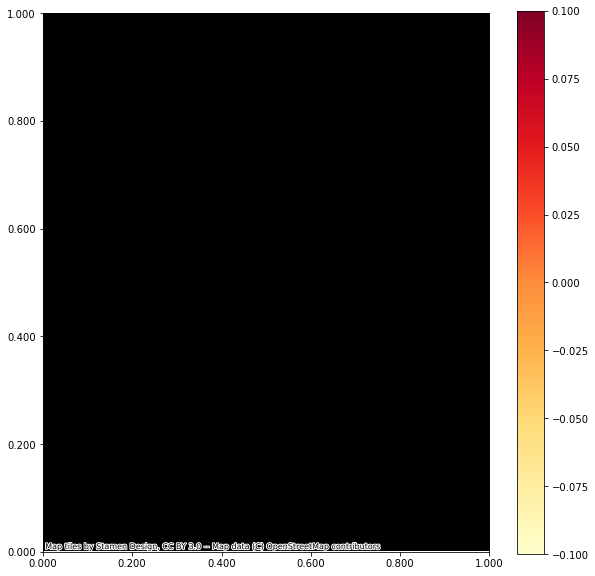

In [699]:
# plot to visualize
ax = ahf_com.plot(figsize=(10,10), column='ahf', alpha=0.7, legend=True, cmap='YlOrRd')#, vmin=0, vmax=5, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc_com.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_overlay_intersection_com.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.4)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [689]:
"""
I noticed that some AHF values for some cells seemed to be suspiciously large.
Turns out this is due to mixed-use buildings and some parking lots included as commercial structures. 
Temporary solution: weight by building footprint instead of volume until more permanent solution.
"""
# === Weight by area ===
# total building area in this neighborhood?
total_building_area_usc_com = buildings_usc_overlay_intersection_com['AREA'].sum()

# add column that describes the fraction of the whole building that segment represents
buildings_usc_overlay_intersection_com['building_fraction'] = buildings_usc_overlay_intersection_com.to_crs('epsg:3857').geometry.area/buildings_usc_overlay_intersection_com['shape_area_whole']
buildings_usc_overlay_intersection_com['AREA'] = buildings_usc_overlay_intersection_com['building_fraction']*buildings_usc_overlay_intersection_com['AREA']

# df of total building volume in each grid cell
building_area_df_com = buildings_usc_overlay_intersection_com[['grid_cell_index', 'AREA']]
area_by_cell_com = building_area_df_com.groupby('grid_cell_index').sum()
# make the index a column
area_by_cell_com.reset_index(inplace=True)

# add cells with no buildings 
area_by_cell_all_com = area_by_cell_com.merge(grid_usc_com, how='outer') # outer join
area_by_cell_all_com = area_by_cell_all_com[['grid_cell_index','AREA','pct_elec','usage_joules','grid_geometry']] # only keep these columns

In [668]:
# calculate AREA-based weights and finally, the AHF
ahf_com['AREA'] = area_by_cell_all_com['AREA']
ahf_com['AREA'] = ahf_com['AREA'].fillna(0)
ahf_com['area_frac'] = ahf_com['AREA']/total_building_area_usc_com
ahf_com['electricity_use_area_weighted'] = ahf_com['pct_elec']*ahf_com['usage_joules']*ahf_com['area_frac']
ahf_com['ahf_area_weighted'] = ahf_com['electricity_use_area_weighted']/cell_area/seconds_in_year
ahf_com.head()

grid_cell_index         VOLUME  pct_elec  usage_joules  \
0              206   21013.637382  0.444748  2.660564e+14   
1              211   29784.498056  0.444748  2.660564e+14   
2              212    6688.903394  0.444748  2.660564e+14   
3              213  241489.692686  0.444748  2.660564e+14   
4              214   56508.294132  0.444748  2.660564e+14   

                                       grid_geometry  vol_frac  \
0  POLYGON ((-118.29112 34.01788, -118.29112 34.0...  0.000337   
1  POLYGON ((-118.29112 34.02161, -118.29112 34.0...  0.000477   
2  POLYGON ((-118.29112 34.02235, -118.29112 34.0...  0.000107   
3  POLYGON ((-118.29112 34.02310, -118.29112 34.0...  0.003868   
4  POLYGON ((-118.29112 34.02384, -118.29112 34.0...  0.000905   

   electricity_use       ahf          AREA  area_frac  \
0     3.982516e+10  0.126269   1277.560466   0.000144   
1     5.644775e+10  0.178972   1845.384018   0.000208   
2     1.267685e+10  0.040193    414.430198   0.000047   
3     4.576726e+11  1.451086  11990.550779   0.001351   
4     1.070948e+11  0.339552   2805.774287   0.000316   

   electricity_use_area_weighted  ahf_area_weighted  
0                   1.703891e+10           0.054023  
1                   2.461201e+10           0.078034  
2                   5.527283e+09           0.017525  
3                   1.599188e+11           0.507035  
4                   3.742080e+10           0.118646

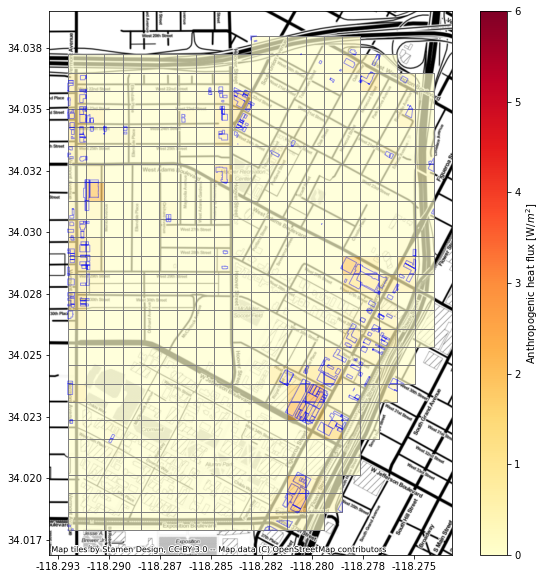

In [669]:
# plot to visualize
ax = ahf_com.plot(figsize=(10,10), column='ahf_area_weighted', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc_com.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_overlay_intersection_com.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.4)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [673]:
ahf.head()

grid_cell_index         VOLUME  pct_elec  usage_joules  \
0              208  383889.604946  0.444748  2.660564e+14   
1              209  190788.635726  0.444748  2.660564e+14   
2              214   32892.316677  0.444748  2.660564e+14   
3              215  199189.571702  0.444748  2.660564e+14   
4              216  162447.525434  0.444748  2.660564e+14   

                                       grid_geometry  vol_frac  \
0  POLYGON ((-118.29112 34.01937, -118.29112 34.0...  0.002831   
1  POLYGON ((-118.29112 34.02012, -118.29112 34.0...  0.001407   
2  POLYGON ((-118.29112 34.02384, -118.29112 34.0...  0.000243   
3  POLYGON ((-118.29112 34.02458, -118.29112 34.0...  0.001469   
4  POLYGON ((-118.29112 34.02533, -118.29112 34.0...  0.001198   

   electricity_use       ahf  electricity_use_naive  ahf_naive  
0     3.349587e+11  1.062012           2.414860e+11    0.76565  
1     1.664706e+11  0.527808           2.414860e+11    0.76565  
2     2.869984e+10  0.090995           2.414860e+11    0.76565  
3     1.738007e+11  0.551049           2.414860e+11    0.76565  
4     1.417418e+11  0.449403           2.414860e+11    0.76565

In [672]:
ahf_com.head()

grid_cell_index         VOLUME  pct_elec  usage_joules  \
0              206   21013.637382  0.444748  2.660564e+14   
1              211   29784.498056  0.444748  2.660564e+14   
2              212    6688.903394  0.444748  2.660564e+14   
3              213  241489.692686  0.444748  2.660564e+14   
4              214   56508.294132  0.444748  2.660564e+14   

                                       grid_geometry  vol_frac  \
0  POLYGON ((-118.29112 34.01788, -118.29112 34.0...  0.000337   
1  POLYGON ((-118.29112 34.02161, -118.29112 34.0...  0.000477   
2  POLYGON ((-118.29112 34.02235, -118.29112 34.0...  0.000107   
3  POLYGON ((-118.29112 34.02310, -118.29112 34.0...  0.003868   
4  POLYGON ((-118.29112 34.02384, -118.29112 34.0...  0.000905   

   electricity_use       ahf          AREA  area_frac  \
0     3.982516e+10  0.126269   1277.560466   0.000144   
1     5.644775e+10  0.178972   1845.384018   0.000208   
2     1.267685e+10  0.040193    414.430198   0.000047   
3     4.576726e+11  1.451086  11990.550779   0.001351   
4     1.070948e+11  0.339552   2805.774287   0.000316   

   electricity_use_area_weighted  ahf_area_weighted  electricity_use_naive  \
0                   1.703891e+10           0.054023           2.414860e+11   
1                   2.461201e+10           0.078034           2.414860e+11   
2                   5.527283e+09           0.017525           2.414860e+11   
3                   1.599188e+11           0.507035           2.414860e+11   
4                   3.742080e+10           0.118646           2.414860e+11   

   ahf_naive  
0    0.76565  
1    0.76565  
2    0.76565  
3    0.76565  
4    0.76565

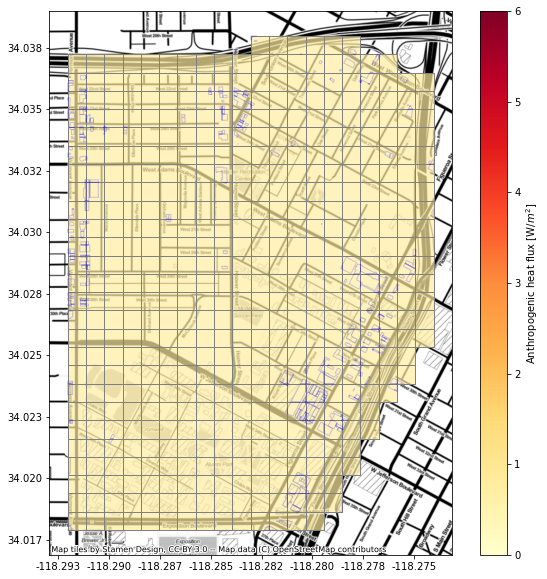

In [671]:
# plot AHF with naive averaging (i.e., no building volume weights)
ahf_com['electricity_use_naive'] = (ahf_com['pct_elec']*ahf_com['usage_joules'])/n_cells
ahf_com['ahf_naive'] = ahf_com['electricity_use_naive']/cell_area/seconds_in_year
ax = ahf_com.plot(figsize=(10,10), column='ahf_naive', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6,legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc_com.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_overlay_intersection_com.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

## Commercial + Residential Combined

### Proof of concept: University Park neighborhood

In [628]:
ahf_combined = ahf.copy()
ahf_combined['ahf'] = ahf['ahf'] + ahf_com['ahf_area_weighted']
ahf_combined['ahf_naive'] = ahf['ahf_naive'] + ahf_com['ahf_naive']

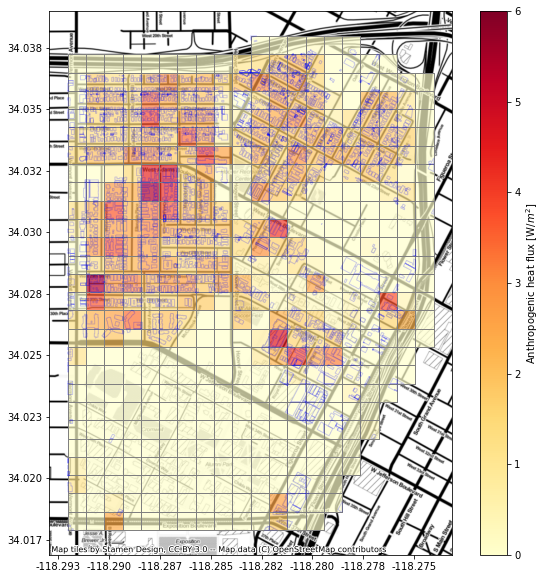

In [632]:
# plot with building weighting applied
ax = ahf_combined.plot(figsize=(10,10), column='ahf', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_overlay_intersection.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
buildings_usc_overlay_intersection_com.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

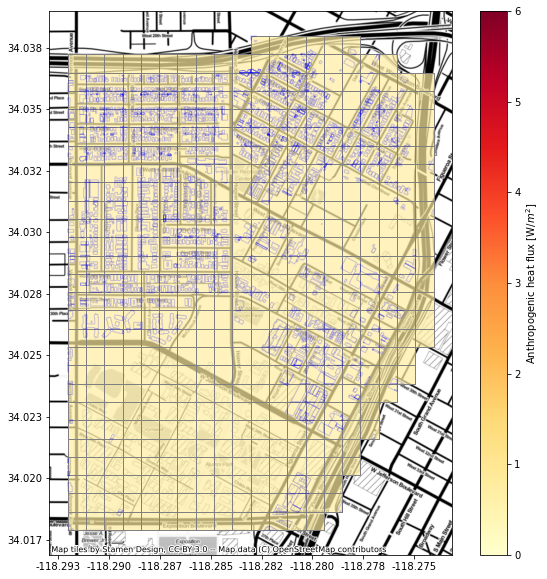

In [633]:
# plot without building weighting (i.e., naive)
ax = ahf_com.plot(figsize=(10,10), column='ahf_naive', alpha=0.7, legend=True, cmap='YlOrRd', vmin=0, vmax=6, legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=lariac_usc_merged_inner.crs) # notice the crs must match between basemap and data
grid_usc.plot(ax=ax, facecolor="none", edgecolor='gray')
buildings_usc_overlay_intersection.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
buildings_usc_overlay_intersection_com.plot(ax=ax, facecolor="none", edgecolor='blue', alpha=0.2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))